In [2]:
import os
from argparse import ArgumentParser

import torch
import torch.utils.data as data
from config import LIDConfig
from Datasets.datasetLID import collate_fn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from tqdm import tqdm

# SEED=100
# pl.utilities.seed.seed_everything(SEED)
# torch.manual_seed(SEED)


hparams = LIDConfig()

import pandas as pd

import torch
from torch.utils.data import Dataset
import torch.nn.utils.rnn as rnn_utils

import torchaudio

import wavencoder
import librosa
import random

def collate_fn(batch):
    (seq, wav_duration, label) = zip(*batch)
    seql = [x.reshape(-1,) for x in seq]
    seq_length = [x.shape[0] for x in seql]
    data = rnn_utils.pad_sequence(seql, batch_first=True, padding_value=0)
    return data, seq_length, label

class LIDDataset(Dataset):
    def __init__(self,
    CSVPath,
    hparams,
    is_train=True,
    ):
        self.CSVPath = CSVPath
        self.data = pd.read_csv(CSVPath).values
        self.is_train = is_train
        self.classes = {
            'ara-acm': torch.eye(14)[0], 
            'ara-apc': torch.eye(14)[1], 
            'ara-ary': torch.eye(14)[2], 
            'ara-arz': torch.eye(14)[3], 
            'eng-gbr': torch.eye(14)[4], 
            'eng-usg': torch.eye(14)[5], 
            'qsl-pol': torch.eye(14)[6], 
            'qsl-rus': torch.eye(14)[7], 
            'por-brz': torch.eye(14)[8], 
            'spa-car': torch.eye(14)[9], 
            'spa-eur': torch.eye(14)[10], 
            'spa-lac': torch.eye(14)[11], 
            'zho-cmn': torch.eye(14)[12], 
            'zho-nan': torch.eye(14)[13]
            }
        self.upsample = torchaudio.transforms.Resample(orig_freq=8000, new_freq=16000)
        # self.train_transform = wavencoder.transforms.PadCrop(pad_crop_length=16000*6, pad_position='random', crop_position='random')
        # self.test_transform = wavencoder.transforms.PadCrop(pad_crop_length=16000*6, pad_position='left', crop_position='center')

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        file = self.data[idx][0]
        language = self.classes[self.data[idx][1]]

        wav, _ = librosa.load(file, sr=8000)
        wav = torch.from_numpy(wav)
        
        if(self.data.shape[1] == 3):
            wav_duration = self.data[idx][2]
        else:
            wav_duration = -1

        return wav, torch.FloatTensor([wav_duration]), language

train_set = LIDDataset(
    CSVPath = hparams.train_path,
    hparams = hparams,
    is_train=False,
)
val_set = LIDDataset(
    CSVPath = hparams.val_path,
    hparams = hparams,
    is_train=False,
)
test_set = LIDDataset(
    CSVPath = hparams.test_path,
    hparams = hparams,
    is_train=False,
)

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [3]:
import pandas as pd
df = pd.read_csv(hparams.test_path)
df['audiopath'][0], df.head()

('/root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre17/data/eval/lre17_srlrablb.sph',
                                            audiopath    class  seconds
 0  /root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre1...  ara-acm        3
 1  /root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre1...  qsl-rus       10
 2  /root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre1...  ara-ary       10
 3  /root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre1...  spa-lac       30
 4  /root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre1...  ara-apc       10)

In [18]:
import IPython
wav, sr = librosa.load(df['audiopath'][0])
IPython.display.Audio(wav.reshape(-1), sr)

OSError: [Errno 9] Bad file descriptor

: 

In [17]:
wav.reshape(-1)

array([ 0.09729354,  0.11681715,  0.11750314, ..., -0.00251748,
       -0.00157617,  0.        ], dtype=float32)

In [9]:
for i in range(len(df['audiopath'])):
    wav, sr = librosa.load(df['audiopath'][i])
    print(sr)

22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050
22050


KeyboardInterrupt: 

100%|██████████| 25222/25222 [00:07<00:00, 3442.04it/s]


(8.789905637935137, 30, 3)

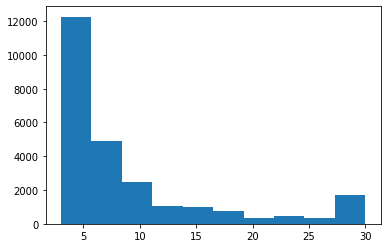

In [29]:
lens = []
for i in tqdm(range(len(train_set))):
    wav_len = int(train_set[i][0].shape[-1]/8000)
    lens.append(wav_len)
_= plt.hist(lens)
sum(lens)/len(lens), max(lens), min(lens)

100%|██████████| 2787/2787 [00:01<00:00, 2520.96it/s]


(20.78471474703983, 89, 3)

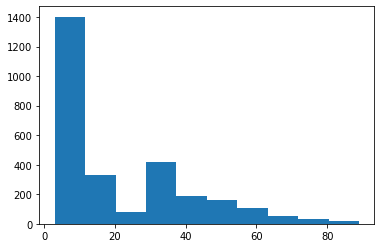

In [30]:
lens = []
for i in tqdm(range(len(val_set))):
    wav_len = int(val_set[i][0].shape[-1]/8000)
    lens.append(wav_len)
_= plt.hist(lens)
sum(lens)/len(lens), max(lens), min(lens)

100%|██████████| 21930/21930 [00:09<00:00, 2433.81it/s]


(21.255038759689924, 90, 3)

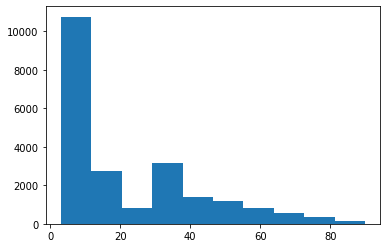

In [31]:
lens = []
for i in tqdm(range(len(test_set))):
    wav_len = int(test_set[i][0].shape[-1]/8000)
    lens.append(wav_len)
_= plt.hist(lens)
sum(lens)/len(lens), max(lens), min(lens)

In [5]:
from Datasets.datasetLID import LIDDataset
import os
from argparse import ArgumentParser

import torch
import torch.utils.data as data
from config import LIDConfig
from Datasets.datasetLID import collate_fn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from tqdm import tqdm

# SEED=100
# pl.utilities.seed.seed_everything(SEED)
# torch.manual_seed(SEED)


hparams = LIDConfig()

import pandas as pd

import torch
from torch.utils.data import Dataset
import torch.nn.utils.rnn as rnn_utils

import torchaudio

import wavencoder
import librosa
import random
train_set = LIDDataset(
    CSVPath = hparams.train_path,
    hparams = hparams,
    is_train=True,
)

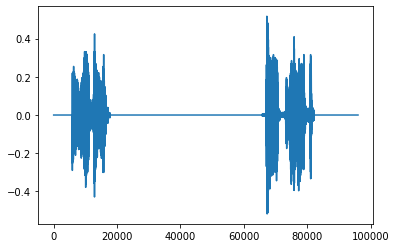

: 

In [6]:
wav = train_set[0][0].view(-1)
plt.plot(wav)


In [ ]:
import wavencoder
import torch

x = torch.randn(1, 16000)
trans = wavencoder.transforms.TimeMask

In [19]:
import pandas as pd
import librosa
import soundfile as sf

TARGET_SR = 16000
df = pd.read_csv(hparams.test_path)


for i in range(len(df)):
    file_name = df['audiopath'][0]
    wav, sr = librosa.load(file_name)
    wav = librosa.resample(wav, orig_sr=sr, target_sr=TARGET_SR)
    save_path = "/root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre17/data/eval_16k/"
    sf.write(save_path + file_name.split("/")[-1].split(".")[0]+".wav", wav, TARGET_SR)

(85775,)
(62241,)


In [13]:
file_name

'/root/LRE2017Dataset/LRE2017/LRE2017_Eval/lre17/data/eval/lre17_srlrablb.sph'

In [4]:
import pandas as pd


csv_path = "/root/LRE2017Dataset/LRE2017_16k/testset.csv"
df = pd.read_csv(csv_path)
# df["audiopath"] = df["audiopath"].str.replace('.sph', '.wav')
df = df.drop("Unnamed: 0",axis=1)
# df = df.drop("Unnamed: 0.1",axis=1)
df.to_csv(csv_path, index=False)
df.head()

,audiopath,class,seconds
0,/root/LRE2017Dataset/LRE2017_16k/eval/lre17_sr...,ara-acm,3
1,/root/LRE2017Dataset/LRE2017_16k/eval/lre17_il...,qsl-rus,10
2,/root/LRE2017Dataset/LRE2017_16k/eval/lre17_vn...,ara-ary,10
3,/root/LRE2017Dataset/LRE2017_16k/eval/lre17_rl...,spa-lac,30
4,/root/LRE2017Dataset/LRE2017_16k/eval/lre17_ks...,ara-apc,10


: 

In [4]:
import pandas as pd


csv_path = "/root/LRE2017Dataset/LRE2017_16k/valset.csv"
df = pd.read_csv(csv_path)

for index, row in df.iterrows():
    file = row["audiopath"]
    if file.endswith(".wav.wav"):
        print(file)
        

/root/LRE2017Dataset/LRE2017_16k/dev/lre17_ccjr.wav.wav


In [5]:
file = "/root/LRE2017Dataset/LRE2017_16k/dev/lre17_ccjr.wav.wav"
file[:-4]

'/root/LRE2017Dataset/LRE2017_16k/dev/lre17_ccjr.wav'